In [34]:
import pathlib
import shutil
import tempfile

import tensorflow as tf
from tensorflow import keras

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [8]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [9]:
gz = keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 60s 0us/step 


In [10]:
FEATURES = 28

In [49]:
ds = tf.data.experimental.CsvDataset(
    filenames=gz,
    record_defaults=[float(), ] * (FEATURES + 1), # float() is 0.0
    compression_type='GZIP'
)

In [50]:
def pack_row(*row):
    # The input is list of all features
    label = row[0]
    # Stack all features for one sample
    features = tf.stack(row[1:], axis=1)
    return features, label

In [72]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

In [73]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [81]:
validate_ds = packed_ds.take(N_VALIDATION).cache().batch(BATCH_SIZE)
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache().repeat().batch(BATCH_SIZE)

In [82]:
## setup learning rate scheduler
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=STEPS_PER_EPOCH * 1000, # every 1000 epoch
    decay_rate=1,
    staircase=False
)

In [83]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        keras.callbacks.TensorBoard(logdir/name)
    ]

In [84]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='elu', input_shape=[FEATURES,]),
    keras.layers.Dense(1)
])

In [85]:
model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
        'accuracy'
    ]
)

In [86]:
model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=10000,
    validation_data=validate_ds,
    callbacks=get_callbacks('model_name'),
    verbose=0
)


Epoch: 0, accuracy:0.5031,  binary_crossentropy:0.8075,  loss:0.8075,  val_accuracy:0.4880,  val_binary_crossentropy:0.7786,  val_loss:0.7786,  
....................................................................................................
Epoch: 100, accuracy:0.6000,  binary_crossentropy:0.6275,  loss:0.6275,  val_accuracy:0.5760,  val_binary_crossentropy:0.6264,  val_loss:0.6264,  
....................................................................................................
Epoch: 200, accuracy:0.6212,  binary_crossentropy:0.6141,  loss:0.6141,  val_accuracy:0.6050,  val_binary_crossentropy:0.6132,  val_loss:0.6132,  
....................................................................................................
Epoch: 300, accuracy:0.6436,  binary_crossentropy:0.6045,  loss:0.6045,  val_accuracy:0.6180,  val_binary_crossentropy:0.6053,  val_loss:0.6053,  
....................................................................................................
Epoch: 40

In [91]:
histories = {'history': model.history}

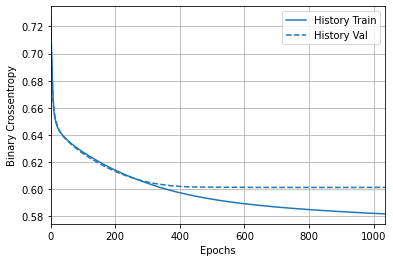

In [92]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(histories)